# Importação das bibliotecas necessárias

In [1]:
from scipy.stats import chi2_contingency
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
import autosklearn.classification
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import joblib
import datetime
import warnings
warnings.filterwarnings('ignore')

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from pandas_profiling import ProfileReport
from unidecode import unidecode


from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_roc_curve


from skopt import BayesSearchCV

from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

import lime
import lime.lime_tabular

# Criação de dataset

In [2]:
df = pd.read_feather('../data/carteira_total.feather')


In [3]:
df.head(3)

mÊs    ID CRM  ID NAVPLAT      ID SAP REGIÃO      CIDADE      BAIRRO  \
0 2020-01-01  10400005    10400005  2000340391     DF  SOBRADINHO  Sobradinho   
1 2020-01-01  10400007    10400007  2000340644     DF    BRASÍLIA     Asa Sul   
2 2020-01-01  10400014    10400014  2000254856     DF    BRASÍLIA     Asa Sul   

   VALOR MENSAL  VALOR HOJE UPSALE/DOWNSALE  ...  LEADS FORM LEADS VER DATO  \
0         434.4       434.4              ok  ...        21.0          100.0   
1         312.0       312.0              ok  ...        18.0          106.0   
2        1798.8      1798.8              ok  ...       174.0          520.0   

  LEADS TOTAL Custo por lead total  Total Contratado  TOTAL DE LISTINGS  \
0       121.0             3.590083              50.0                  9   
1       124.0             2.516129              25.0                  7   
2       694.0             2.591931           10031.0                 67   

   CUSTO POR LISTING  PF/PJ  Total Utilizado  Faixa Listings  
0          48.266667     PJ              9.0          6 – 10  
1          44.571429     PF              7.0          6 – 10  
2          26.847761     PJ             67.0        61 – 100  

[3 rows x 36 columns]

# Pandas Proffling

In [4]:
# prof = ProfileReport(df)
# prof.to_file(output_file='output.html')

In [5]:
# Missing Values
# contratado_freemium (52.1%) - Quantidade de zeros (25.9%)
# utilizado_freemium (52.1%) - Quantidade de zeros (44.5%)

# possui_midia_ativa_ (0.6%) - categorica
# custo_por_lead_total (0.4%)
# total_contratado (0.4%)
# utilizado_super_destaques (< 0.1%)
# utilizado_destaque (< 0.1%)
# utilizado_ofertas_simples (< 0.1%)
# leads_form (< 0.1%)
# leads_ver_dato (< 0.1%)
# leads_total (< 0.1%)
# custo_por_listing (< 0.1%)
# total_utilizado (< 0.1%)
# faixa_listings (< 0.1%) - categorica


# EDA

Remoção dos acentos das colunas e alteração dos caracteres diferentes de alfa numérico para "_"

In [6]:
newColumnsName = []
for column_name in df:
  newColumnsName.append(re.sub('[^A-Za-z0-9]+', '_', unidecode(column_name).lower()))
df.columns = newColumnsName

Criação da coluna churn, e definição do seu valor com base nos valores da coluna upsale_downsale (churn = 1, demais valores = 0). Decidimos excluir a coluna upsell_downsell (por não ter mais importância para a análise)

In [7]:
df["upsale_downsale"].replace({"Churn": "churn", "Upsell": "upsell", "Downsell": "downsell", "Ok": "ok"}, inplace=True)
df['churn'] = df['upsale_downsale']
df['churn'].replace({"ok": "0", "upsell": "0", "downsell": "0", "churn": "1"}, inplace=True)

df.drop(columns = ["upsale_downsale"], inplace = True)

In [8]:
df.head(3)

mes    id_crm  id_navplat      id_sap regiao      cidade      bairro  \
0 2020-01-01  10400005    10400005  2000340391     DF  SOBRADINHO  Sobradinho   
1 2020-01-01  10400007    10400007  2000340644     DF    BRASÍLIA     Asa Sul   
2 2020-01-01  10400014    10400014  2000254856     DF    BRASÍLIA     Asa Sul   

   valor_mensal  valor_hoje  faturamento  ... leads_ver_dato leads_total  \
0         434.4       434.4        434.0  ...          100.0       121.0   
1         312.0       312.0        312.0  ...          106.0       124.0   
2        1798.8      1798.8       1799.0  ...          520.0       694.0   

  custo_por_lead_total  total_contratado  total_de_listings  \
0             3.590083              50.0                  9   
1             2.516129              25.0                  7   
2             2.591931           10031.0                 67   

   custo_por_listing  pf_pj  total_utilizado  faixa_listings  churn  
0          48.266667     PJ              9.0          6 – 10      0  
1          44.571429     PF              7.0          6 – 10      0  
2          26.847761     PJ             67.0        61 – 100      0  

[3 rows x 36 columns]

status_final, valor_hoje, faturamento, custo_por_lead_total, custo_por_listing



In [9]:
df['custo_por_listing'][df['churn'] == 1]


Series([], Name: custo_por_listing, dtype: float64)

#### Adição da coluna quantidade_mes respectiva a quantidade de meses os ID SAP é cliente

In [10]:
df_grouped = df[['mes', 'id_sap']].groupby(['id_sap']).count().reset_index()

df_grouped.rename(columns = {'mes':'quantidade_mes'}, inplace=True)

In [11]:
df_grouped.sample(2)


id_sap  quantidade_mes
12349  2001034927               7
2284   2000261374              18

In [12]:
df = df.join(df_grouped.set_index('id_sap'), on='id_sap')
    

In [13]:
df.sample(2)

mes    id_crm  id_navplat      id_sap regiao  cidade bairro  \
131474 2021-08-01  47401262    47394148  2001551051     SP  SUMARÉ    nan   
62418  2020-11-01  30002510    30002510  2000262943     SP  OSASCO  KM 18   

        valor_mensal  valor_hoje  faturamento  ... leads_total  \
131474          99.0        99.0         99.0  ...         8.0   
62418          699.0       699.0        699.0  ...       459.0   

       custo_por_lead_total total_contratado  total_de_listings  \
131474            12.375000             10.0                 10   
62418              1.522876          10056.0               1342   

        custo_por_listing  pf_pj  total_utilizado  faixa_listings  churn  \
131474           9.900000     PJ             10.0          6 – 10      0   
62418            0.520864     PJ           1342.0     1001 – 2000      0   

        quantidade_mes  
131474              10  
62418               22  

[2 rows x 37 columns]

#### Definição do quality score de cada registro

In [14]:
xls = pd.ExcelFile('../data/quality_score.xlsx')
xls.sheet_names

i = 0
for data in xls.sheet_names:
    if i == 0:
        dfQuality = pd.read_excel(xls, data)
        dfQuality['data'] = data
        dfQuality.rename(columns={'Classificação Pagamento': 'status_pagamento', 'Quality Score Cobrança': 'status_pagamento',
                                  'PFIN': 'status_pagamento', 'PEFIN': 'status_pagamento'}, inplace=True)
    else:
        dfQualityAux = pd.read_excel(xls, data)
        dfQualityAux['data'] = data
        dfQualityAux.rename(columns={'Classificação Pagamento': 'status_pagamento', 'Quality Score Cobrança': 'status_pagamento',
                                     'PFIN': 'status_pagamento', 'PEFIN': 'status_pagamento'}, inplace=True)

        dfQuality = pd.concat([dfQuality, dfQualityAux])

    i+=1

In [15]:
dfQuality['status_pagamento'].unique()


array(['4. Péssimo', '2. Regular ', '1. Bom', '3. Ruim', '5. Novo', 'C2C',
       '2. Regular', '1. Bom ', 'lançamentos', nan, '5. novo', 0],
      dtype=object)

In [16]:
dfQuality['status_pagamento'].replace({'4. Péssimo': 'Pessimo', '2. Regular ': 'Regular', '1. Bom': 'Bom', '3. Ruim': 'Ruim', '5. Novo': 'Novo',
                                       '2. Regular': 'Regular', '1. Bom ': 'Bom', 'lançamentos': np.nan, '5. novo': 'Novo', 0: np.nan}, inplace=True)


In [17]:
dfQuality.head()


ID SAP status_pagamento   data
0  2000252554          Pessimo  out20
1  2000251191          Regular  out20
2  2000251824              Bom  out20
3  2000248936              Bom  out20
4  2000252090              Bom  out20

In [18]:
dfQuality.dropna(inplace=True)

In [19]:
dfQuality['status_pagamento'].isna().sum()


0

In [20]:
regex = r'([0-9]{4})-([0-9]{2})-[0-9]{2}'

def fun_replace(data): 
    return datetime.datetime.strptime(str(data.group(2)).lower(), '%m').strftime('%b').lower() + data.group(1)[-2:]

df['mes'] = df['mes'].astype(str).str.replace(regex, fun_replace, regex=True)


In [21]:
dfQuality.columns


Index(['ID SAP', 'status_pagamento', 'data'], dtype='object')

In [22]:
df.columns

Index(['mes', 'id_crm', 'id_navplat', 'id_sap', 'regiao', 'cidade', 'bairro',
       'valor_mensal', 'valor_hoje', 'faturamento', 'oficina',
       'frequencia_de_faturamento', 'tipo_de_plano',
       'contratado_super_destaques', 'contratado_destaques',
       'contratado_ofertas_simples', 'contratado_freemium',
       'utilizado_super_destaques', 'utilizado_destaque',
       'utilizado_ofertas_simples', 'utilizado_freemium',
       'executivo_carteira_atual', 'equipe', 'status_final',
       'possui_midia_ativa_', 'leads_form', 'leads_ver_dato', 'leads_total',
       'custo_por_lead_total', 'total_contratado', 'total_de_listings',
       'custo_por_listing', 'pf_pj', 'total_utilizado', 'faixa_listings',
       'churn', 'quantidade_mes'],
      dtype='object')

In [23]:
dfQuality.rename(columns={'ID SAP': 'id_sap', 'data' : 'mes'}, inplace=True)

In [24]:
df = df.join(dfQuality.set_index(['id_sap', 'mes']), on=['id_sap', 'mes'])


## Padronizando valores categóricos

### Oficina

In [25]:
df['oficina'].unique()

array(['WI', 'IW'], dtype=object)

In [26]:
df['oficina'].replace({'wi': 'WI'}, inplace=True) # Alterando o valor wi para igualar a WI
df['oficina'].unique()

array(['WI', 'IW'], dtype=object)

### Faturamento

In [27]:
df['frequencia_de_faturamento'].unique()

array(['Mensal', 'Anual', 'Semestral', 'Trimestral', 'MENSAL', 'ANUAL',
       'SEMESTRAL', 'TRIMESTRAL', '0'], dtype=object)

In [28]:
#corrigir diferenças de nomes
df['frequencia_de_faturamento'] = df['frequencia_de_faturamento'].str.lower()
df['frequencia_de_faturamento'].unique()

array(['mensal', 'anual', 'semestral', 'trimestral', '0'], dtype=object)

In [29]:
#remover espaços

df['frequencia_de_faturamento'] = df['frequencia_de_faturamento'].str.strip()
df['frequencia_de_faturamento'].unique()

array(['mensal', 'anual', 'semestral', 'trimestral', '0'], dtype=object)

In [30]:
#renomeando unica vez

df['frequencia_de_faturamento'].replace({'única vez': 'unica_vez'}, inplace=True)
df['frequencia_de_faturamento'].unique()

array(['mensal', 'anual', 'semestral', 'trimestral', '0'], dtype=object)

### Tipo de Plano

In [31]:
df['tipo_de_plano'].unique()

array(['LIMITADO', 'ILIMITADO', 'nan', 'SIMPLES', 'PACK', '0'],
      dtype=object)

### Midia Ativa

In [32]:
df['possui_midia_ativa_'].unique()

array(['No', 'Si', None], dtype=object)

### PF_PJ

In [33]:
df['pf_pj'].unique()

array(['PJ', 'PF'], dtype=object)

### Equipe

In [34]:
df['equipe'].unique()

array(['Regional DF', 'Relacionamento', 'JUMBO', 'Resellers', 'Jumbo',
       'Mídias', 'RELACIONAMENTO', 'RESELLERS', 'REGIONAL DF'],
      dtype=object)

In [35]:
# Alterando para valores ficarem iguais
df['equipe'].replace({'Relacionamento': 'RELACIONAMENTO', 'Jumbo': 'JUMBO',
                     'Resellers': 'RESELLERS', 'Regional DF': 'REGIONAL DF'}, inplace=True)
df['equipe'].unique()

array(['REGIONAL DF', 'RELACIONAMENTO', 'JUMBO', 'RESELLERS', 'Mídias'],
      dtype=object)

In [36]:
df.columns

Index(['mes', 'id_crm', 'id_navplat', 'id_sap', 'regiao', 'cidade', 'bairro',
       'valor_mensal', 'valor_hoje', 'faturamento', 'oficina',
       'frequencia_de_faturamento', 'tipo_de_plano',
       'contratado_super_destaques', 'contratado_destaques',
       'contratado_ofertas_simples', 'contratado_freemium',
       'utilizado_super_destaques', 'utilizado_destaque',
       'utilizado_ofertas_simples', 'utilizado_freemium',
       'executivo_carteira_atual', 'equipe', 'status_final',
       'possui_midia_ativa_', 'leads_form', 'leads_ver_dato', 'leads_total',
       'custo_por_lead_total', 'total_contratado', 'total_de_listings',
       'custo_por_listing', 'pf_pj', 'total_utilizado', 'faixa_listings',
       'churn', 'quantidade_mes', 'status_pagamento'],
      dtype='object')



---



## Drop das colunas "contratado_freemium" e "utilizado_freemium" por possuírem diversos valores nulos e zerados

In [37]:
df.drop(['contratado_freemium', 'utilizado_freemium'], axis=1, inplace=True)

## Correlações

# Data Cleaning and Data Wrangling

### Criação de novo dataframe com somente as colunas relevantes

In [38]:
# pode influenciar tanto que talvez seja melhor remover:
# status_final, valor_hoje, faturamento, custo_por_lead_total, custo_por_listing

# pode influenciar muito:
# pf_pj, faixa_listings, contratado_ofertas_simples, utilizado_ofertas_simples,
# leads_form, leads_ver_dato, leads_total, total_contratado, total_de_listings,
# total_utilizado, quantidade_mes, status_pagamento

# pode influenciar:
# tipo_de_plano, equipe, contratado_super_destaques, utilizado_super_destaques, 
# utilizado_destaque

# pode influenciar pouco:
# possui_midia_ativa_, valor_mensal

In [39]:
df.columns

Index(['mes', 'id_crm', 'id_navplat', 'id_sap', 'regiao', 'cidade', 'bairro',
       'valor_mensal', 'valor_hoje', 'faturamento', 'oficina',
       'frequencia_de_faturamento', 'tipo_de_plano',
       'contratado_super_destaques', 'contratado_destaques',
       'contratado_ofertas_simples', 'utilizado_super_destaques',
       'utilizado_destaque', 'utilizado_ofertas_simples',
       'executivo_carteira_atual', 'equipe', 'status_final',
       'possui_midia_ativa_', 'leads_form', 'leads_ver_dato', 'leads_total',
       'custo_por_lead_total', 'total_contratado', 'total_de_listings',
       'custo_por_listing', 'pf_pj', 'total_utilizado', 'faixa_listings',
       'churn', 'quantidade_mes', 'status_pagamento'],
      dtype='object')

In [40]:
# df = df[['pf_pj', 'contratado_ofertas_simples', 'utilizado_ofertas_simples',
#          'leads_form', 'leads_ver_dato', 'total_contratado', 'total_de_listings',
#          'total_utilizado', 'equipe', 'contratado_super_destaques', 'utilizado_super_destaques',
#          'utilizado_destaque', 'valor_mensal', 'quantidade_mes', 'status_pagamento', 'churn']].copy()


In [41]:
dfCategoricals = df.select_dtypes(include=['object']).drop(columns='churn')

print('Possuem correlação entre si:')
listaCatCorrChurn = []
for serie1 in dfCategoricals:
    for serie2 in dfCategoricals:
        if serie1 == serie2:
            continue
        crosstab = pd.crosstab(df[serie1], df[serie2])
        stat, p, dof, expected = chi2_contingency(crosstab)
        if (p < 0.05):
            listaCatCorrChurn.append([serie1, serie2])

print(listaCatCorrChurn)


Possuem correlação entre si:
[['mes', 'regiao'], ['mes', 'bairro'], ['mes', 'oficina'], ['mes', 'frequencia_de_faturamento'], ['mes', 'tipo_de_plano'], ['mes', 'executivo_carteira_atual'], ['mes', 'equipe'], ['mes', 'status_final'], ['mes', 'possui_midia_ativa_'], ['mes', 'pf_pj'], ['mes', 'faixa_listings'], ['mes', 'status_pagamento'], ['regiao', 'mes'], ['regiao', 'cidade'], ['regiao', 'bairro'], ['regiao', 'oficina'], ['regiao', 'frequencia_de_faturamento'], ['regiao', 'tipo_de_plano'], ['regiao', 'executivo_carteira_atual'], ['regiao', 'equipe'], ['regiao', 'status_final'], ['regiao', 'possui_midia_ativa_'], ['regiao', 'pf_pj'], ['regiao', 'faixa_listings'], ['regiao', 'status_pagamento'], ['cidade', 'regiao'], ['cidade', 'bairro'], ['cidade', 'oficina'], ['cidade', 'frequencia_de_faturamento'], ['cidade', 'tipo_de_plano'], ['cidade', 'executivo_carteira_atual'], ['cidade', 'equipe'], ['cidade', 'status_final'], ['cidade', 'possui_midia_ativa_'], ['cidade', 'pf_pj'], ['cidade', 'fa

### Plot do gráfico de correlação entre variáveis preditoras

<AxesSubplot:>

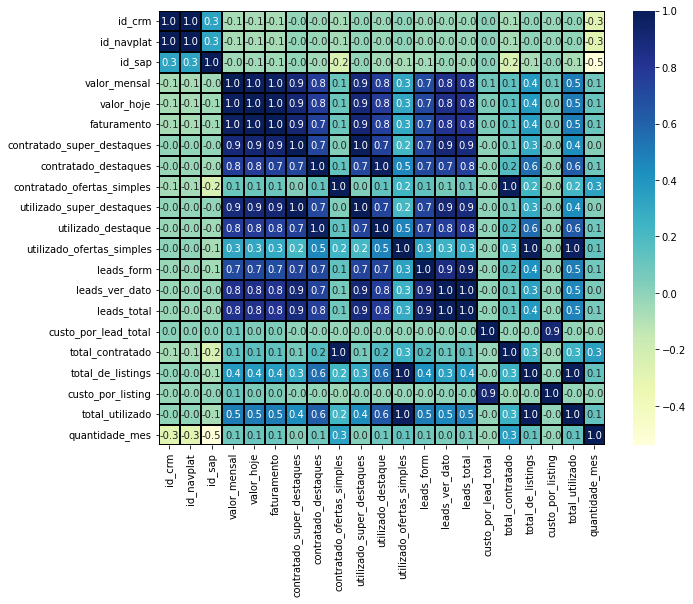

In [42]:
corr = df.corr()

plt.subplots(figsize=(10, 8))
sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt=".1f", linecolor="black", linewidths="0.1", )

In [43]:
numericalColumns = df.select_dtypes(include=np.number)

df = df[df['status_pagamento'].notna()]
df[numericalColumns.columns] = numericalColumns.fillna(
    numericalColumns.median())

for col in numericalColumns:
    df[col][df[col] < 1] = 1


In [44]:
def calculaVIF():
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.select_dtypes(include=np.number).columns

    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(df.select_dtypes(include=np.number).values, i)
                    for i in range(len(df.select_dtypes(include=np.number).columns))]

    return vif_data

calculaVIF()

feature            VIF
0                       id_crm    2400.161861
1                   id_navplat    2400.216501
2                       id_sap      17.851165
3                 valor_mensal      49.694987
4                   valor_hoje     109.036456
5                  faturamento      94.916365
6   contratado_super_destaques     798.624910
7         contratado_destaques      16.210106
8   contratado_ofertas_simples      21.553440
9    utilizado_super_destaques    1234.531595
10          utilizado_destaque      59.932900
11   utilizado_ofertas_simples    5969.258407
12                  leads_form   37423.270688
13              leads_ver_dato  242453.675234
14                 leads_total  448296.193709
15        custo_por_lead_total       1.317729
16            total_contratado      22.274804
17           total_de_listings     216.654464
18           custo_por_listing       1.342670
19             total_utilizado    8044.792175
20              quantidade_mes       1.423807

In [45]:
df.drop(columns=['total_utilizado', 'contratado_super_destaques', 'total_de_listings',
        'total_contratado', 'leads_ver_dato', 'utilizado_super_destaques'], inplace=True)


In [46]:
calculaVIF()

feature          VIF
0                       id_crm  2400.113658
1                   id_navplat  2400.167575
2                       id_sap    17.609274
3                 valor_mensal    44.285794
4                   valor_hoje   103.527643
5                  faturamento    83.450837
6         contratado_destaques    12.718945
7   contratado_ofertas_simples     1.278442
8           utilizado_destaque    16.771551
9    utilizado_ofertas_simples     1.481900
10                  leads_form    11.059402
11                 leads_total    20.699388
12        custo_por_lead_total     1.313770
13           custo_por_listing     1.335937
14              quantidade_mes     1.374839

In [47]:
# [['mes', 7.803875491087676e-132], ['regiao', 6.56369686341621e-238], ['cidade', 0.0], ['bairro', 0.0], ['oficina', 2.4104151625154287e-87], 
# ['frequencia_de_faturamento', 1.576888167035842e-86], ['tipo_de_plano', 0.0], 
# ['executivo_carteira_atual', 0.0], ['equipe', 0.0], ['status_final', 0.0], ['possui_midia_ativa_', 0.0], ['pf_pj', 0.0], ['faixa_listings', 0.0], 
# ['status_pagamento', 6.753642576277686e-142]]

In [48]:
df.columns

Index(['mes', 'id_crm', 'id_navplat', 'id_sap', 'regiao', 'cidade', 'bairro',
       'valor_mensal', 'valor_hoje', 'faturamento', 'oficina',
       'frequencia_de_faturamento', 'tipo_de_plano', 'contratado_destaques',
       'contratado_ofertas_simples', 'utilizado_destaque',
       'utilizado_ofertas_simples', 'executivo_carteira_atual', 'equipe',
       'status_final', 'possui_midia_ativa_', 'leads_form', 'leads_total',
       'custo_por_lead_total', 'custo_por_listing', 'pf_pj', 'faixa_listings',
       'churn', 'quantidade_mes', 'status_pagamento'],
      dtype='object')

In [49]:
df.dtypes

mes                            object
id_crm                          int64
id_navplat                      int64
id_sap                          int64
regiao                         object
cidade                         object
bairro                         object
valor_mensal                  float64
valor_hoje                    float64
faturamento                   float64
oficina                        object
frequencia_de_faturamento      object
tipo_de_plano                  object
contratado_destaques            int64
contratado_ofertas_simples      int64
utilizado_destaque            float64
utilizado_ofertas_simples     float64
executivo_carteira_atual       object
equipe                         object
status_final                   object
possui_midia_ativa_            object
leads_form                    float64
leads_total                   float64
custo_por_lead_total          float64
custo_por_listing             float64
pf_pj                          object
faixa_listin

In [50]:
df = df[['pf_pj', 'contratado_ofertas_simples', 'utilizado_ofertas_simples',
         'leads_form', 'equipe', 'utilizado_destaque', 'valor_mensal',
         'quantidade_mes', 'status_pagamento', 'churn', 'regiao', 'oficina', 'tipo_de_plano', 'frequencia_de_faturamento']].copy()


<AxesSubplot:>

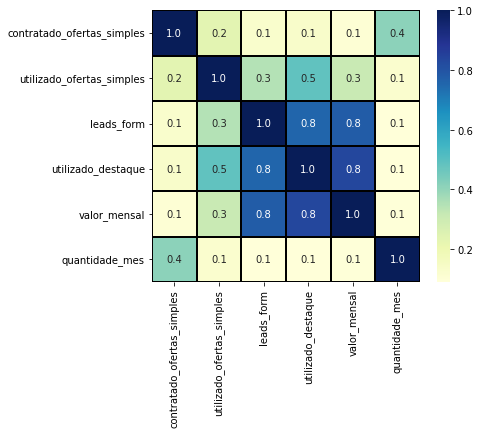

In [51]:
corr = df.corr()

plt.subplots(figsize=(6, 5))
sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt=".1f",
            linecolor="black", linewidths="0.1", )


In [52]:
df.isna().sum()

pf_pj                         0
contratado_ofertas_simples    0
utilizado_ofertas_simples     0
leads_form                    0
equipe                        0
utilizado_destaque            0
valor_mensal                  0
quantidade_mes                0
status_pagamento              0
churn                         0
regiao                        0
oficina                       0
tipo_de_plano                 0
frequencia_de_faturamento     0
dtype: int64

# Modeling

### Tratatamento das variáveis numéricas e categóricas

In [53]:
# dummy_df = pd.get_dummies(df[[
#     'pf_pj', 'equipe', 'status_pagamento']], drop_first=True)
# df = df.join(dummy_df)
# df.drop(columns=['pf_pj', 'equipe', 'status_pagamento'], inplace=True)


In [54]:
dfCategoricals = df.select_dtypes(include=['object']).drop(columns='churn')

print('Possuem correlação entre si:')
listaCatCorrChurn = []
for serie1 in dfCategoricals:
    for serie2 in dfCategoricals:
        if serie1 == serie2:
            continue
        crosstab = pd.crosstab(df[serie1], df[serie2])
        stat, p, dof, expected = chi2_contingency(crosstab)
        if (p < 0.05):
            listaCatCorrChurn.append([serie1, serie2])

print(listaCatCorrChurn)


Possuem correlação entre si:
[['pf_pj', 'equipe'], ['pf_pj', 'status_pagamento'], ['pf_pj', 'regiao'], ['pf_pj', 'oficina'], ['pf_pj', 'tipo_de_plano'], ['equipe', 'pf_pj'], ['equipe', 'status_pagamento'], ['equipe', 'regiao'], ['equipe', 'oficina'], ['equipe', 'tipo_de_plano'], ['equipe', 'frequencia_de_faturamento'], ['status_pagamento', 'pf_pj'], ['status_pagamento', 'equipe'], ['status_pagamento', 'regiao'], ['status_pagamento', 'oficina'], ['status_pagamento', 'tipo_de_plano'], ['status_pagamento', 'frequencia_de_faturamento'], ['regiao', 'pf_pj'], ['regiao', 'equipe'], ['regiao', 'status_pagamento'], ['regiao', 'oficina'], ['regiao', 'tipo_de_plano'], ['oficina', 'pf_pj'], ['oficina', 'equipe'], ['oficina', 'status_pagamento'], ['oficina', 'regiao'], ['oficina', 'tipo_de_plano'], ['tipo_de_plano', 'pf_pj'], ['tipo_de_plano', 'equipe'], ['tipo_de_plano', 'status_pagamento'], ['tipo_de_plano', 'regiao'], ['tipo_de_plano', 'oficina'], ['frequencia_de_faturamento', 'equipe'], ['frequ

In [55]:
df = df[['pf_pj', 'contratado_ofertas_simples', 'utilizado_ofertas_simples',
         'leads_form', 'equipe', 'utilizado_destaque', 'valor_mensal',
         'quantidade_mes', 'status_pagamento', 'churn', 'regiao', 'oficina', 'tipo_de_plano', 'frequencia_de_faturamento']].copy()


In [56]:
dummy_df = pd.get_dummies(df[[
    'pf_pj', 'equipe', 'status_pagamento', 'regiao', 'oficina', 'tipo_de_plano', 'frequencia_de_faturamento']], drop_first=True)
df = df.join(dummy_df)
df.drop(columns=['pf_pj', 'equipe', 'status_pagamento', 'regiao',
        'oficina', 'tipo_de_plano', 'frequencia_de_faturamento'], inplace=True)


### Separação do dataset em treino, validação e teste

In [57]:
X = df.drop(['churn'], axis=1)
y = df['churn'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

X_train = pd.DataFrame(X_train, columns=X_train.columns)
y_train = pd.Series(y_train)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1)  # 0.25 x 0.8 = 0.2


In [58]:
def trataDados(df_dados, target):
    # Balanceamento dos dados
    sm = SMOTE(sampling_strategy='minority', random_state=7)
    df_dados, target = sm.fit_resample(df_dados, target.filter(df_dados.index))

    # Normalização dos dados
    numericalColumns = ['contratado_ofertas_simples', 'utilizado_ofertas_simples', 'leads_form',
                        'utilizado_destaque', 'valor_mensal', 'quantidade_mes']
    df_dados[numericalColumns] = RobustScaler().fit_transform(df_dados[numericalColumns])

    return df_dados, target

X_train, y_train = trataDados(X_train, y_train)
X_val, y_val = trataDados(X_val, y_val)
X_test, y_test = trataDados(X_test, y_test)

#### Execução do modelo

#### Cross validation da base de treino com todos os modelos

In [59]:
def executeCrossValidation(model, X_train, y_train):
    cv = KFold(n_splits=5, random_state=1, shuffle=True)


    scores = cross_validate(model, X_train, y_train,
                            scoring=['accuracy', 'precision', 'recall', 'f1'], cv=cv, n_jobs=-1)

    for f1, accuracy, precision, recall in zip(scores['test_accuracy'], scores['test_precision'], scores['test_recall'], scores['test_f1']):
        print(f"F1 Score: {f1}%")
        print(f"Accuracy Score: {accuracy}%")
        print(f"Precision Score: {precision}%")
        print(f"Recall Score: {recall}%")
        print()


In [60]:
# print('Random Forest')
# print('-' * 30)
# executeCrossValidation(RandomForestClassifier(n_jobs=-1, random_state=1),
#                    X_train, y_train)
# print()
# print('Gradient Boosting')
# print('-' * 30)
# executeCrossValidation(GradientBoostingClassifier(
#     random_state=1), X_train, y_train)
# print()
# print('Multilayer Perceptron')
# print('-' * 30)
# executeCrossValidation(MLPClassifier(hidden_layer_sizes=(6, 5),
#                                  random_state=1,
#                                  verbose=True,
#                                  learning_rate_init=0.01), X_train, y_train)
# print()
# print('KNN')
# print('-' * 30)
# executeCrossValidation(KNeighborsClassifier(n_neighbors=7),
#                    X_train, y_train)


#### Execução e avaliação dos modelos

In [61]:
def executeModel(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y=y_train)

    predictDataSet = model.predict(X_test)

    f1 = round(f1_score(y_test, predictDataSet, average='macro')*100, 2)
    accuracy = round(accuracy_score(y_test, predictDataSet)*100, 2)
    precision = round(precision_score(y_test, predictDataSet)*100, 2)
    recall = round(recall_score(y_test, predictDataSet)*100, 2)

    print(f"F1 Score: {f1}%")
    print(f"Accuracy Score: {accuracy}%")
    print(f"Precision Score: {precision}%")
    print(f"Recall Score: {recall}%")

    plot_confusion_matrix(model, X_test, y_test, display_labels=[
                        "positivo", "negativo"], values_format="d")
    plt.grid(False)
    plt.show()

    plot_roc_curve(model, X_test, y_test)
    plt.show()

Random Forest
------------------------------
F1 Score: 89.46%
Accuracy Score: 89.47%
Precision Score: 91.96%
Recall Score: 86.5%


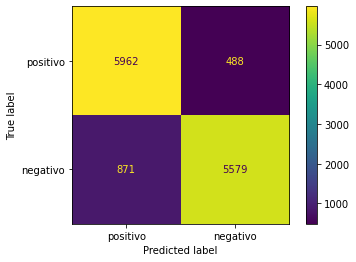

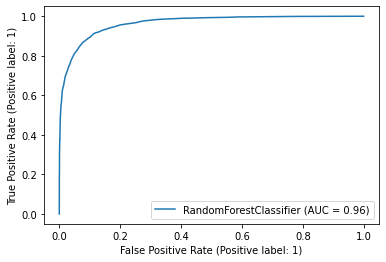


Gradient Boosting
------------------------------
F1 Score: 88.6%
Accuracy Score: 88.62%
Precision Score: 85.49%
Recall Score: 93.02%


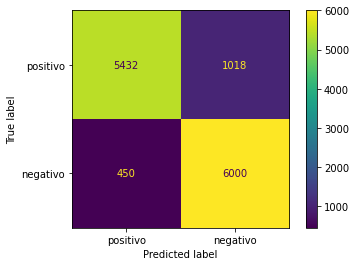

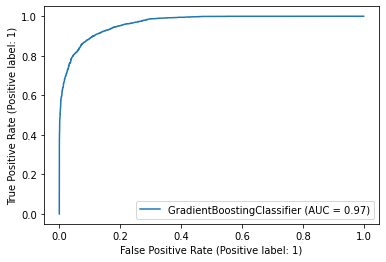


Multilayer Perceptron
------------------------------
Iteration 1, loss = 0.35079312
Iteration 2, loss = 0.24163514
Iteration 3, loss = 0.23658298
Iteration 4, loss = 0.23187912
Iteration 5, loss = 0.22914637
Iteration 6, loss = 0.22765960
Iteration 7, loss = 0.22240383
Iteration 8, loss = 0.22110828
Iteration 9, loss = 0.22150995
Iteration 10, loss = 0.21721521
Iteration 11, loss = 0.21812671
Iteration 12, loss = 0.21660841
Iteration 13, loss = 0.21463052
Iteration 14, loss = 0.21663670
Iteration 15, loss = 0.21506242
Iteration 16, loss = 0.21494938
Iteration 17, loss = 0.21356931
Iteration 18, loss = 0.21081665
Iteration 19, loss = 0.21235876
Iteration 20, loss = 0.21173956
Iteration 21, loss = 0.21108871
Iteration 22, loss = 0.20955401
Iteration 23, loss = 0.20892902
Iteration 24, loss = 0.20917571
Iteration 25, loss = 0.21123029
Iteration 26, loss = 0.21123372
Iteration 27, loss = 0.20955712
Iteration 28, loss = 0.20696017
Iteration 29, loss = 0.20767659
Iteration 30, loss = 0.2083

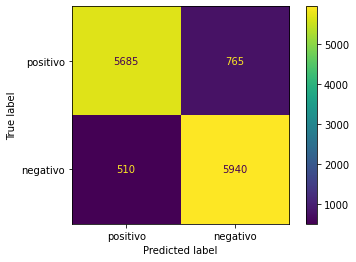

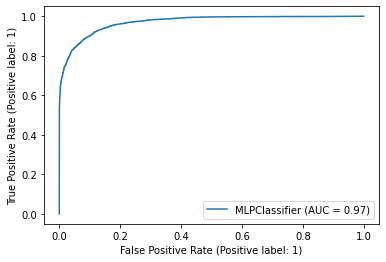


KNN
------------------------------
F1 Score: 86.4%
Accuracy Score: 86.4%
Precision Score: 87.52%
Recall Score: 84.91%


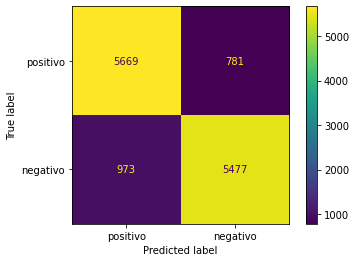

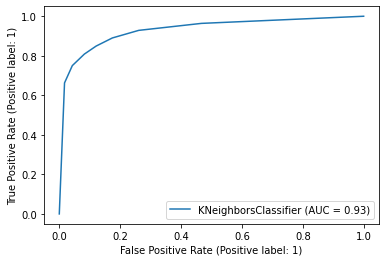

In [62]:
print('Random Forest')
print('-' * 30)
executeModel(RandomForestClassifier(n_jobs=-1, random_state=1), X_train, y_train, X_val, y_val)
print()
print('Gradient Boosting')
print('-' * 30)
executeModel(GradientBoostingClassifier(
    random_state=1), X_train, y_train, X_val, y_val)
print()
print('Multilayer Perceptron')
print('-' * 30)
executeModel(MLPClassifier(hidden_layer_sizes=(6, 5),
                           random_state=1,
                           verbose=True,
                           learning_rate_init=0.01), X_train, y_train, X_val, y_val)
print()
print('KNN')
print('-' * 30)                           
executeModel(KNeighborsClassifier(n_neighbors=7),
             X_train, y_train, X_val, y_val)


### Tunning de hiperparâmetros do melhor modelo

In [ ]:
n_estimators = [int(x) for x in np.linspace(start=1, stop=500, num=25)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 112, num=12)]
min_samples_split = [2, 6, 10]
min_samples_leaf = [1, 3, 4]
bootstrap = [True, False]
criterion = ['gini', 'entropy']

parameters = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap,
              'criterion': criterion}

bayes_search = BayesSearchCV(RandomForestClassifier(n_jobs=-1), search_spaces=parameters, cv=3, n_jobs=-1, verbose=10)
bayes_search.fit(X_train, y_train)


In [ ]:
bayes_search.best_estimator_


RandomForestClassifier(bootstrap=False, max_depth=40, max_features='sqrt',
                       n_estimators=20, n_jobs=-1)

In [66]:
clf = MLPClassifier(hidden_layer_sizes=(6, 5),
                    random_state=1,
                    verbose=True,
                    learning_rate_init=0.01)


Gradient Boosting
------------------------------
F1 Score: 88.6%
Accuracy Score: 88.62%
Precision Score: 85.49%
Recall Score: 93.02%


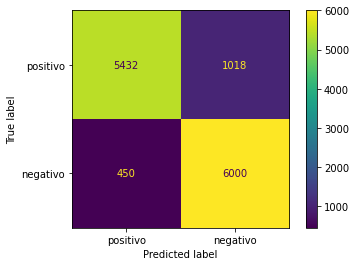

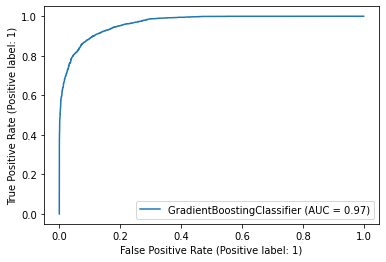

In [68]:
print('MLP')
print('-' * 30)
executeModel(clf, X_train, y_train, X_val, y_val)


In [ ]:
joblib.dump(clf, 'GB_churn_imovel_web.pkl')


['GB_churn_imovel_web.pkl']

### Avaliação da performance do modelo com os dados de teste


In [ ]:
y_pred = clf.predict(X_test)

data_set_valid = X_test.reset_index(drop=True)
y_real = pd.Series(y_test).reset_index(drop=True)
y_predito = pd.Series(y_pred, name='churn_predito').reset_index(drop=True)

df_teste = pd.concat([data_set_valid, y_real, y_predito], axis=1)

Quantidade total: 12924
Preditos Corretamente: 11083
Preditos Icorretamente: 1841


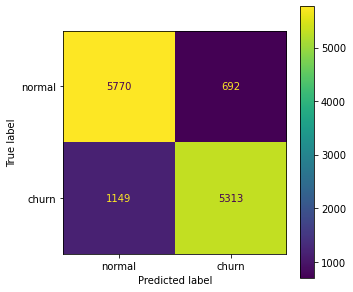

In [ ]:
print('Quantidade total: {}'.format(len(df_teste)))
print('Preditos Corretamente: {}'.format(len(df_teste[df_teste['churn'] == df_teste['churn_predito']])))
print('Preditos Icorretamente: {}'.format(len(df_teste[df_teste['churn'] != df_teste['churn_predito']])))


plot_confusion_matrix(clf, X_test, y_test, display_labels=[
                      "normal", "churn"], values_format="d")


### Interpretabilidade individual do resultado dos registros classificados pelo modelo

In [ ]:
def predict_explainer(df_fil):
    ''' Apresenta o explain das probabilidades que definiram o registro como "churn" ou não '''
    index_registro_visualizacao = df_fil.sample().index[0]

    print('Quantidade de registros preditos nessa categoria: {}'.format(len(df_fil)))
    print()
    print('-' * 5 + ' Churn Real / Churn Predito ' + '-' * 5)
    print()
    print(df_teste[['churn', 'churn_predito']
                   ].iloc[index_registro_visualizacao])
    print()
    print('-' * 5 + ' Probabilidade ' + '-' * 5)

    explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train),
                                                   feature_names=X_train.columns,
                                                   class_names=[
                                                       "Não Churn", "Churn"],
                                                   mode='classification')

    exp = explainer.explain_instance(X_val.iloc[index_registro_visualizacao],
                                     clf.predict_proba,
                                     num_features=10,
                                     top_labels=1)

    return exp.show_in_notebook(show_table=True, show_all=False)


In [ ]:
# Reseta os índices para que possamos procurar os registros

X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)


#### Explain aleatório dos "Churns" considerados "Churn" pelo modelo

In [ ]:
df_fil = df_teste[(df_teste['churn'] == df_teste['churn_predito']) & (df_teste['churn'] == 1)]
predict_explainer(df_fil)


Quantidade de registros preditos nessa categoria: 5313

----- Churn Real / Churn Predito -----

churn            1
churn_predito    1
Name: 8070, dtype: int64

----- Probabilidade -----


#### Explain aleatório dos "Não Churns" considerados "Não Churn" pelo modelo

In [422]:
df_fil = df_teste[(df_teste['churn'] == df_teste['churn_predito']) & (df_teste['churn'] == 0)]
predict_explainer(df_fil)


Quantidade de registros preditos nessa categoria: 5770

----- Churn Real / Churn Predito -----

churn            0
churn_predito    0
Name: 2425, dtype: int64

----- Probabilidade -----


#### Explain aleatório dos "Churns" considerados "Não Churn"

In [423]:
df_fil = df_teste[(df_teste['churn'] != df_teste['churn_predito']) & (df_teste['churn'] == 1)]
predict_explainer(df_fil)

Quantidade de registros preditos nessa categoria: 1149

----- Churn Real / Churn Predito -----

churn            1
churn_predito    0
Name: 8145, dtype: int64

----- Probabilidade -----


#### Explain aleatório dos "Não Churn" considerados "Churn"

In [424]:
df_fil = df_teste[(df_teste['churn'] != df_teste['churn_predito']) & (df_teste['churn'] == 0)]
predict_explainer(df_fil)

Quantidade de registros preditos nessa categoria: 692

----- Churn Real / Churn Predito -----

churn            0
churn_predito    1
Name: 3842, dtype: int64

----- Probabilidade -----
